In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from pandas import read_csv, set_option
import pandas as pd
from pandas.plotting import scatter_matrix

df = pd.read_csv('/content/gdrive/My Drive/BTC-USD (82).csv') #BTC-USD.csv

df.interpolate(inplace=True) 
#df = df.dropna()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-09,18320.884766,18626.292969,17935.546875,18553.916016,18553.916016,34420373071
1,2020-12-10,18553.298828,18553.298828,17957.064453,18264.992188,18264.992188,25547132265
2,2020-12-11,18263.929688,18268.453125,17619.533203,18058.904297,18058.904297,27919640985
3,2020-12-12,18051.320313,18919.550781,18046.041016,18803.656250,18803.656250,21752580802
4,2020-12-13,18806.765625,19381.535156,18734.332031,19142.382813,19142.382813,25450468637
...,...,...,...,...,...,...,...
361,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,49368.847656,37198201161
362,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,50582.625000,37707308001
363,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,50700.085938,33676814852
364,2021-12-08,50667.648438,51171.375000,48765.988281,50504.796875,50504.796875,28479699446


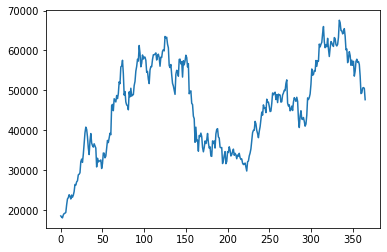

In [3]:
df1=df.reset_index()['Close']

import matplotlib.pyplot as plt
plt.plot(df1)

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))


In [5]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]



In [6]:

training_size,test_size

(292, 74)

In [7]:
train_data

array([[0.00999864],
       [0.00416273],
       [0.        ],
       [0.01504309],
       [0.02188495],
       [0.02399091],
       [0.02743342],
       [0.06568026],
       [0.09586865],
       [0.10259078],
       [0.11737369],
       [0.10944492],
       [0.09582663],
       [0.11562038],
       [0.10467903],
       [0.11466942],
       [0.1334309 ],
       [0.16922812],
       [0.16590053],
       [0.18231232],
       [0.18792008],
       [0.21778431],
       [0.22103162],
       [0.22855428],
       [0.28416387],
       [0.29738915],
       [0.28102592],
       [0.32183788],
       [0.37903951],
       [0.43047935],
       [0.45929426],
       [0.44832505],
       [0.40998563],
       [0.35363535],
       [0.3204347 ],
       [0.38897723],
       [0.42676853],
       [0.37905978],
       [0.36598659],
       [0.35817242],
       [0.3751151 ],
       [0.36379834],
       [0.35325347],
       [0.25787377],
       [0.30190839],
       [0.28295952],
       [0.28743832],
       [0.288

In [8]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 5
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:

print(X_train.shape), print(y_train.shape)

(286, 5)
(286,)


(None, None)

In [11]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

In [13]:
model=Sequential()
model.add(GRU(3,return_sequences=True,input_shape=(time_step,1))) #GRU
model.add(GRU(3,return_sequences=True))
model.add(GRU(3))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 3)              54        
                                                                 
 gru_1 (GRU)                 (None, 5, 3)              72        
                                                                 
 gru_2 (GRU)                 (None, 3)                 72        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


In [15]:
# optional code

i = 0 
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.0016, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        #self.j = j

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)


        #if self.j < 10:
        if current <= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
        
          #self.j=self.j +1
        #else:
         #if current <= 0.05 and current >= 0.045:
            #  if self.verbose > 0:
            #      print("Epoch %05d: early stopping THR" % epoch)
            #  self.model.stop_training = True

callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=0.0016, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    #ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]



In [17]:

history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=4,verbose=1)#, callbacks=callbacks #batch size - 2/4/10/20/26/260


Epoch 1/100
72/72 [==============================] - 8s 27ms/step - loss: 0.1021 - val_loss: 0.0553
Epoch 2/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0230 - val_loss: 0.0412
Epoch 3/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0174 - val_loss: 0.0397
Epoch 4/100
72/72 [==============================] - 1s 10ms/step - loss: 0.0115 - val_loss: 0.0181
Epoch 5/100
72/72 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 6/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0067
Epoch 7/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 8/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 9/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0028

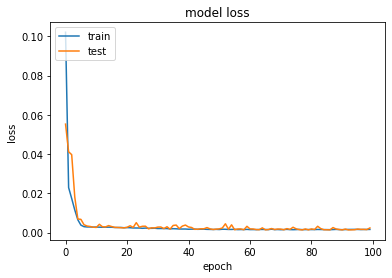

In [18]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
import tensorflow as tf

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

43922.74781271456

In [22]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

57175.652918062355

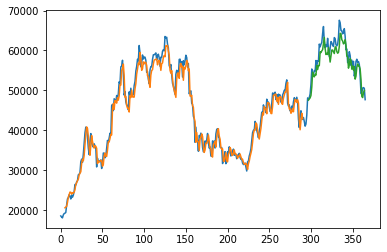

In [23]:


### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
# save model and architecture to single file
#model.save("/content/gdrive/My Drive/mode.h5")
#print("Saved model to disk")


#from keras.models import load_model
 
# load model
#model = load_model('model.h5')

In [25]:
len(test_data)

74

In [26]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape

(1, 5)

In [27]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [28]:
temp_input

[0.6324228716957863,
 0.6569397015312868,
 0.6593122699792806,
 0.6553676678247151,
 0.5981510535542145]

In [29]:

# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<2):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.5907837]
6
1 day input [0.6569397  0.65931227 0.65536767 0.59815105 0.59078372]
1 day output [[0.57609946]]
[[0.5907837152481079], [0.5760994553565979]]


In [30]:

day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+3)

In [31]:
import matplotlib.pyplot as plt
len(df1)

366

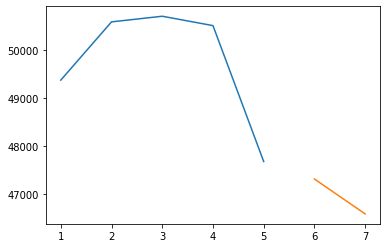

In [32]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [33]:
scaler.inverse_transform(df1[len(df1)-time_step:])

array([[49368.847656],
       [50582.625   ],
       [50700.085938],
       [50504.796875],
       [47672.121094]])

In [34]:
scaler.inverse_transform(lst_output)

array([[47307.37947033],
       [46580.39225015]])

In [35]:

# pridicting using saved model
from keras.models import load_model
 
# load model
model2 = load_model('/content/gdrive/My Drive/mode.h5')



In [36]:

x_input2 = [49200.70, 49368.85, 50582.63, 50700.09, 50504.80, 47672.12, 47243.30]

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
x_input2=scaler.fit_transform(np.array(x_input2).reshape(-1,1))
x_input2

array([[0.56624788],
       [0.61489127],
       [0.9660205 ],
       [1.        ],
       [0.94350539],
       [0.1240515 ],
       [0.        ]])

In [37]:
#scaler.inverse_transform(x_input2)

In [38]:

# demonstrate prediction for next 10 days
from numpy import array

lst_output2=[]
n_steps=7


x_input2 = x_input2.reshape((1, n_steps,1))
yhat2 = model2.predict(x_input2, verbose=0)
#print(yhat2[0])
lst_output2.extend(yhat2.tolist())


print(scaler.inverse_transform(lst_output2))


[[47940.65559869]]
